In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical as rcat
from torch.distributions.gamma import Gamma
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_SAMPLES_SNR = 100
NUM_HIDDEN = 32
NUM_STATS = K+D*K+D*K
NUM_LATENTS = D * K
NUM_OBS_GLOBAL = D + K
NUM_OBS_LOCAL = D + K*D + K*D
TEMP = 0.66
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 50
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
PATH = 'oneshot-rws-nre-probTorch'

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/sequences.npy')).float()
Zs_true = torch.from_numpy(np.load('gmm_dataset/states.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [4]:
class Encoder_init(nn.Module):
    def __init__(self, num_obs=D,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_stats))

        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
        self.mus_mean = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.mus_log_nu = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
        self.prior_mean = torch.zeros(K*D)
        self.prior_nu = torch.ones(K*D) * 0.3
        self.prior_alpha = torch.ones(K*D) * 3.0
        self.prior_beta = torch.ones(K*D) * 3.0
        if CUDA:
            self.prior_mean = self.prior_mean.cuda()
            self.prior_nu = self.prior_nu.cuda()
            self.prior_alpha = self.prior_alpha.cuda()
            self.prior_beta = self.prior_beta.cuda()
        
    def forward(self, obs):
        q = probtorch.Trace()
        stats = self.enc_stats(obs).sum(-2) ## B * N * D --> B * STATS_DIM 
        q_alpha = self.sigmas_log_alpha(stats).exp() ## B * K * D
        q_beta = self.sigmas_log_beta(stats).exp() ## B * K * D
        precisions = Gamma(q_alpha, q_beta).sample()
        q.gamma(q_alpha, 
                q_beta, 
                value=precisions, 
                name='precisions')
        q_mean = self.mus_mean(stats)
        q_nu = self.mus_log_nu(stats).exp()
        q_sigma = 1. / (q_nu * q['precisions'].value).sqrt() ## S * B * (K*D)
        means = Normal(q_mean, q_sigma).sample()
        q_mu = q.normal(q_mean, 
                        q_sigma, 
                        value=means, 
                        name='means')

        p = probtorch.Trace()
        p.gamma(self.prior_alpha, 
                self.prior_beta, 
                value=q['precisions'], 
                name='precisions')
        p.normal(self.prior_mean, 
                 1. / (self.prior_nu * q['precisions'].value).sqrt(), 
                 value=q['means'], 
                 name='means')    
        return q, p
    
class Encoder_local(nn.Module):
    def __init__(self, num_obs=NUM_OBS_LOCAL,
                       num_hidden=NUM_HIDDEN,
                       num_latents=K):
        super(self.__class__, self).__init__()
        self.enc_onehot = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents),
            nn.Softmax(-1))
        
        self.prior_pi = torch.ones(K) * (1./ K)
        if CUDA:
            self.prior_pi = self.prior_pi.cuda()
  
    def forward(self, q_eta, obs):
        q = probtorch.Trace()
        means = q_eta['means'].value.unsqueeze(-2).repeat(1, 1, N, 1)
        precisions = q_eta['precisions'].value.unsqueeze(-2).repeat(1, 1, N, 1)
        data = torch.cat((obs, means, precisions), -1)
        q_pi = self.enc_onehot(data)## S * B * N * (D+2*K*D) --> S * B * N * K
        zs = rcat(temperature=torch.Tensor([TEMP]).cuda(), probs=q_pi).sample()
        q.concrete(temperature=torch.Tensor([TEMP]).cuda(), 
                                      probs=q_pi, 
                                      value=zs,
                                      name='zs')

        p = probtorch.Trace()
        p.concrete(temperature=torch.Tensor([TEMP]).cuda(), 
                                      probs=self.prior_pi,
                                      value=q['zs'], 
                                      name='zs')  
        return q, p
    
def initialize():
    enc_init = Encoder_init()
    enc_local = Encoder_local()
    if CUDA:
        enc_init.cuda()
        enc_local.cuda()
    optimizer =  torch.optim.Adam(list(enc_init.parameters()) + list(enc_local.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_init, enc_local, optimizer

In [5]:
enc_init, enc_local, optimizer = initialize()

In [6]:
EUBOs = []
ELBOs = []
ESSs = []
SNRs = []
Vars = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO, ELBO, ESS, SNR, Var, KLs_eta_ex_os, KLs_eta_in_os, KL_z_ex_os, KL_z_in_os\n')
flog.close()

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    KL_eta_ex_os = 0.0
    KL_eta_in_os = 0.0
    KL_z_ex_os = 0.0
    KL_z_in_os = 0.0
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        data = Xs[batch_indices]
        states_t = Zs_true[batch_indices]
        data, states_t = shuffler(data, states_t, N, K, D, BATCH_SIZE)
        if CUDA:
            data =data.repeat(NUM_SAMPLES, 1, 1, 1).cuda()
            states_t = states_t.repeat(NUM_SAMPLES, 1, 1, 1).cuda() 
        snr, var = SNR_NRe(enc_init, enc_local, optimizer, data, K, D, SAMPLE_DIM, BATCH_DIM, NUM_SAMPLES, BATCH_SIZE, NUM_SAMPLES_SNR)
        SNRs.append(snr.item())
        Vars.append(var.item())
        optimizer.zero_grad()
        
        eubo, elbo, ess, KL_eta_ex, KL_eta_in, KL_z_ex, KL_z_in = rws_nonrep(enc_init, enc_local, data, states_t, N, K, D, SAMPLE_DIM, BATCH_DIM, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        KL_eta_ex_os += KL_eta_ex.item()
        KL_eta_in_os += KL_eta_in.item()
        KL_z_ex_os += KL_z_ex.item()
        KL_z_in_os += KL_z_in.item()       
        flog = open('results/log-' + PATH + '.txt', 'a+')
        flog.write(str(eubo.item()) + ', ' + str(elbo.item()) + ', ' + str(ess.item()) + ', ' + 
                str(snr.item()) + ', ' + str(var.item()) + ', ' +
               str(KL_eta_ex.item()) + ', ' + str(KL_eta_in.item()) + ', ' + str(KL_z_ex.item()) + ', ' + str(KL_z_in.item()) + '\n')
             
    EUBO /= NUM_BATCHES
    ELBO /= NUM_BATCHES
    ESS /= NUM_BATCHES
    KL_eta_ex_os /= NUM_BATCHES
    KL_eta_in_os /= NUM_BATCHES
    KL_z_ex_os /= NUM_BATCHES
    KL_z_in_os /= NUM_BATCHES 
    
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS) 
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, EX_eta=%.3f, IN_eta=%.3f, EX_z=%.3f, IN_z=%.3f (%ds)'
            % (epoch, EUBO, ELBO, ESS,  KL_eta_ex_os, KL_eta_in_os, KL_z_ex_os, KL_z_in_os, time_end - time_start))


epoch=0, EUBO=-272.304, ELBO=-484.075, ESS=1.057, EX_eta=374.379, IN_eta=48.307, EX_z=80.646, IN_z=15.881 (59s)
epoch=1, EUBO=-209.759, ELBO=-293.810, ESS=1.107, EX_eta=179.894, IN_eta=72.448, EX_z=28.732, IN_z=10.506 (59s)
epoch=2, EUBO=-197.454, ELBO=-245.773, ESS=1.191, EX_eta=135.117, IN_eta=119.559, EX_z=19.001, IN_z=7.647 (60s)
epoch=3, EUBO=-191.591, ELBO=-225.564, ESS=1.263, EX_eta=115.245, IN_eta=161.525, EX_z=14.913, IN_z=6.295 (62s)
epoch=4, EUBO=-189.047, ELBO=-216.322, ESS=1.334, EX_eta=107.333, IN_eta=180.308, EX_z=13.526, IN_z=5.908 (61s)
epoch=5, EUBO=-185.874, ELBO=-208.324, ESS=1.380, EX_eta=98.925, IN_eta=184.188, EX_z=11.916, IN_z=5.481 (52s)
epoch=6, EUBO=-184.824, ELBO=-204.061, ESS=1.434, EX_eta=94.295, IN_eta=181.108, EX_z=11.121, IN_z=5.305 (55s)
epoch=7, EUBO=-183.047, ELBO=-200.365, ESS=1.464, EX_eta=90.535, IN_eta=190.117, EX_z=9.541, IN_z=5.011 (58s)
epoch=8, EUBO=-182.414, ELBO=-198.657, ESS=1.480, EX_eta=88.763, IN_eta=188.874, EX_z=9.803, IN_z=5.024 (54s

In [7]:
def plot_results(EUBOs, ELBOs, ESSs, SNRs, Vars, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(15, 15))
    fig.tight_layout()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')
    ax2.set_yscale('log')
    ax2.plot(SNRs, label='SNR')
    ax2.plot(Vars, label='Gradient Varience')
#     ax2.plot(TrueKls_exclusive, '#66b3ff', label='true exclusive KL')
#     ax2.plot(MCKls_exclusive, '#ff9999', label='est exclusive KL')
#     ax2.plot(TrueKls_inclusive, '#99ff99', label='true inclusive KL')
#     ax2.plot(MCKls_inclusive, 'gold', label='est inclusive KL')
    
    ax1.tick_params(labelsize=18)
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-300, -150])
    ax1.legend()
#     ax2.set_ylim([1e-7, 1e5])
    ax2.legend()
    ax3.legend()
    ax2.tick_params(labelsize=18)
    ax3.tick_params(labelsize=18)
    plt.savefig('train_' + PATH + '.svg')

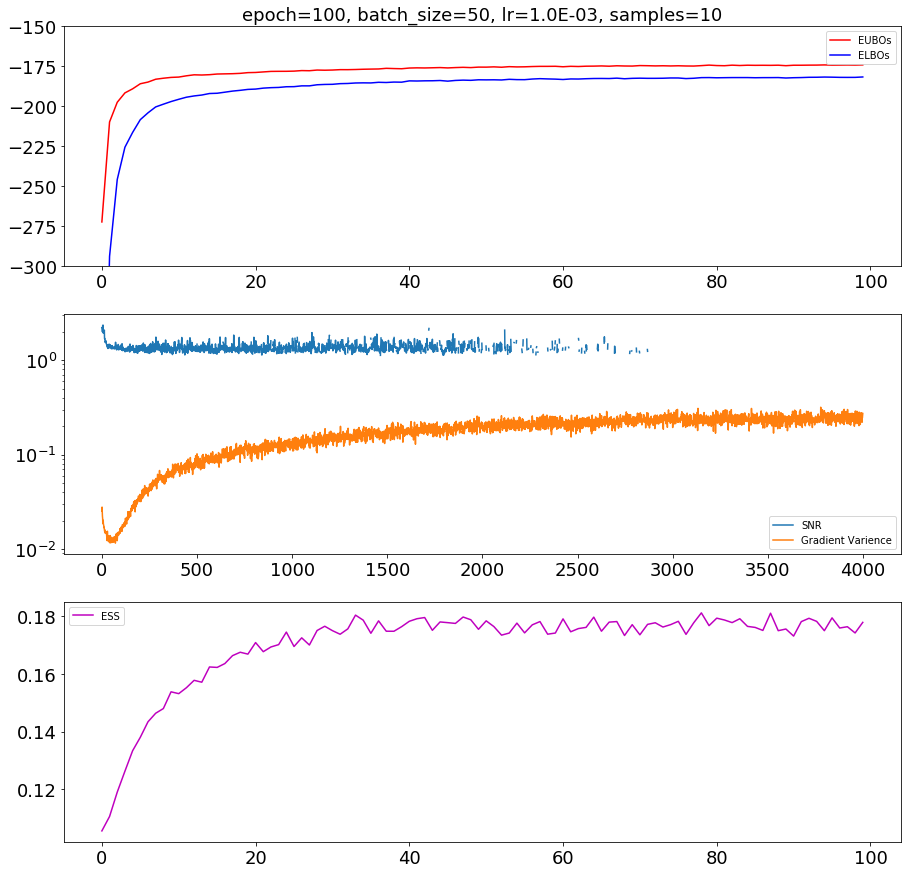

In [8]:
plot_results(EUBOs, ELBOs, ESSs, SNRs, Vars, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)